# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and predict their gender based on face images. Please read carefully all the instructions before you start to write your code.

**Your Tasks**

You are supposed to train two CNN models.
- Model A: Train a CNN model from scratch, following a few restrictions. Save this model as `age_gender_A.keras`
- Model B: Fine-tune a pre-trained model to perform the same task. Save this model as `age_gender_B.keras`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During the assessment phase, your code will be tested on unseen test data.

**Performance Metric**

The evaluation of your models on the test set will be based on the following metrics:
- age estimation: - Mean Absolute Error (MAE)
- gender prediction: accuracy

**GPU Time Management**

Please use the available GPU time wisely, as there are some limitations on free GPU usage. It is said the users can use up to 12 hours in row in Google Colab. But many people found they reached its limit far less than 12 hours. To minimize the risk of reaching the limit, consider the following suggestions:
1. Ensure you have a stable internet connection.
2. Carefully validate your hyperparameters before starting the training process.
3. Based on past experience, each model should be trained in less than 2 hours. If the training time is significantly longer, you may need to adjust your model architecture.


## Setting Up: Mount the google drive
Mount your google drive to the notebook. Also don't forget to **enable GPU** before your training.


In [1]:
#
# Add your code here
#

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It's always beneficial to thoroughly understand your data before beginning the training process. To get a first-hand impression of the dataset, please display a minimum of 20 images from the `train_val/` folder, along with their corresponding age and gender labels. This will help you gain initial insights into the dataset.

[4575, 4478, 2781, 2667, 455, 588, 1715, 3092, 118, 1791, 3537, 4360, 3091, 3551, 4350, 2246, 2210, 1650, 4438, 57]


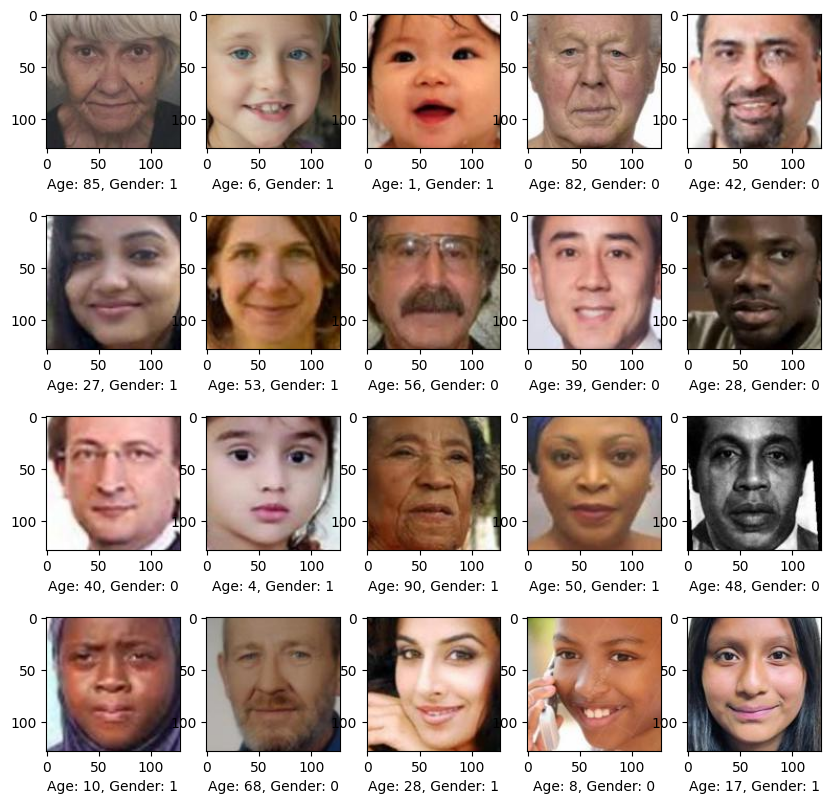

In [2]:
#
# Add your code here
#

# relevant imports
import random
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

# extracting the age and gender from the images
age = []
gender = []
race = []
datetime = []

# folder containing the images
folder = '/content/drive/MyDrive/Colab Notebooks/data/train_val'

# loop through the files and extract the information from the file names
for images in os.listdir(folder):
  labels = images.split('_')
  age.append(labels[0])
  gender.append(labels[1])
  race.append(labels[2])
  datetime.append(labels[3].split('.')[0])

# selecting a random subset of images to display
rand = [random.randint(0,5000) for i in range(20)]
print(rand)

# viewing 20 random images
plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  files = folder + '/' + str(age[rand[i]]) + '_' + str(gender[rand[i]]) + '_' + str(race[rand[i]]) + '_' + str(datetime[rand[i]]) + '.jpg.chip.jpg'
  img = imread(files)
  plt.imshow(img)
  plt.axis
  plt.xlabel(f'Age: {age[rand[i]]}, Gender: {gender[rand[i]]}')

## Step 1: Data Pre-Processing
In this step, you will perform necessary pre-processing tasks before feeding the data into a CNN. The pre-processing includes:

1. Splitting the data into training and validation sets.
2. Loading image data, gender labels and age values, and rescaling pixel values (originally integers between 0 and 255) to the range [0, 1].
3. Data augmentation

The first two pre-processing steps have already been completed for you. Your task in this step is limited to:

3. Data augmentation

Please note:

- Do not modify any part of the provided code except the section marked with ########.
- Do not rescale the age values to the range [0,1], as the original values are used during the testing stage. Rescaling them would significantly impact testing performance.



In [3]:
import os
import random
import numpy as np

# added new imports
import cv2
from tensorflow.keras import layers, Sequential

folder_train_val = '/content/drive/MyDrive/Colab Notebooks/data/train_val'
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
  print('load all image data, age and gender labels...')
  images = []
  age_labels = []
  gender_labels = []
  for current_file_name in filenames:
    img = cv2.imread(os.path.join(dataset_path, current_file_name))
    img = img / 255.0  # Normalize pixel values
    labels = current_file_name.split('_')
    age_label = int(labels[0])
    gender_label = int(labels[1])
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    images.append(img)

  # Convert to NumPy arrays
  images = np.array(images)
  age_labels = np.array(age_labels)
  gender_labels = np.array(gender_labels)
  return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

#
######### Add your code for data augmentation here #########
#

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1,0.1),
    layers.RandomShear(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.002)
])

Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...


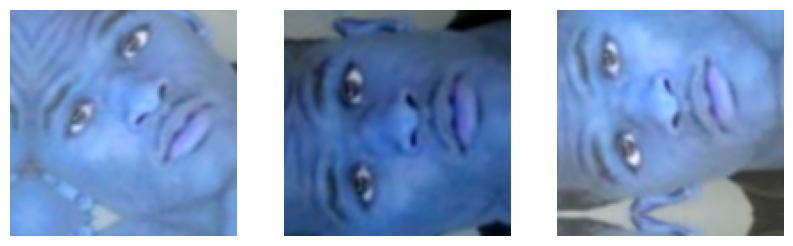

In [4]:
# visualize some of the augmented images

plt.figure(figsize=(10, 10))
for i in range(3):
  augmented_image = data_augmentation(train_images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## STEP2A: Build your own CNN network
In this step, you will define your own CNN model for identifying gender and predicting age. Although there are two tasks, you only need to build one CNN model with two outputs. You may refer to online resources for solutions.

Here are the key requirements and restrictions for your network:
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2. Although it is technically correct to treat gender classification as a multi-class problem with 2 classes, i.e., 2 units in the last layer, the test code only supports a 1-unit last-layer configuration for the gender branch.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	Incorporate techniques to prevent overfitting as appropriate.

At the end of your implementation, use `modelA.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_977CLONE     │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_22             │ (None, 9216)           │        389,856 │ keras_tensor_977CLONE… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 256)            │      2,359,296 │ sequential_22[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_168   │ (None, 256)            │          1,024 │ dense_52[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 512)            │      4,718,592 │ sequential_22[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_168            │ (None, 256)            │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_169   │ (None, 512)            │          2,048 │ dense_53[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_52 (Dropout)      │ (None, 256)            │              0 │ activation_168[1][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_169            │ (None, 512)            │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dropout_52[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            513 │ activation_169[1][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,471,586 (28.50 MB)

 Trainable params: 7,469,090 (28.49 MB)

 Non-trainable params: 2,496 (9.75 KB)

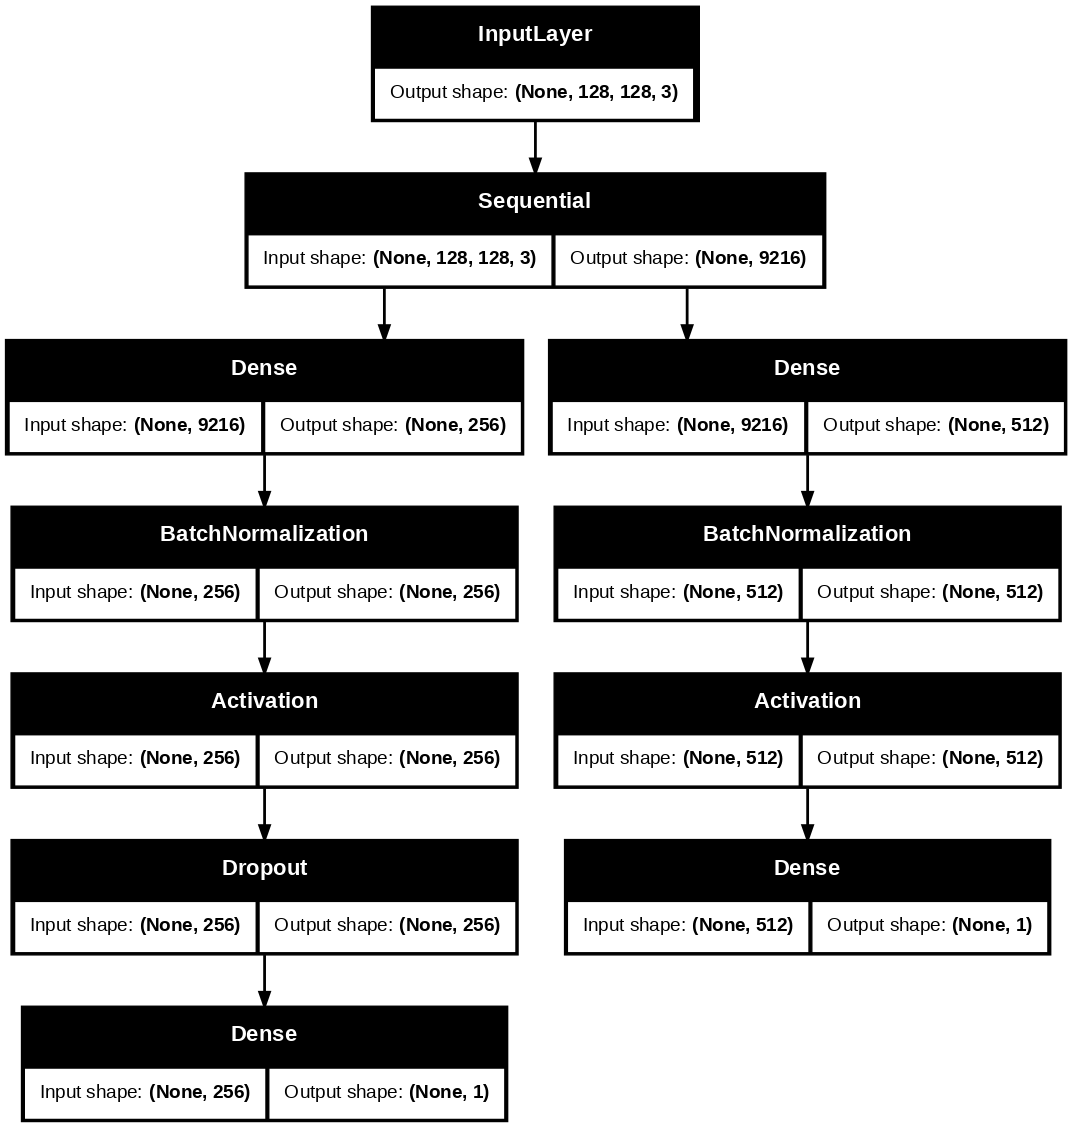

In [57]:
#
# Add your code here
#

# necessary imports
import keras.utils
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Activation, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# initial learning rate and input shape
l2_val = 0.001
input_shape = (128, 128, 3)

# define model architecture
before_fully_conncected = Sequential([

    layers.Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(l2_val), input_shape=input_shape, strides=1, padding = 'same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), use_bias=False, kernel_regularizer=l2(l2_val), strides = 1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), use_bias=False, kernel_regularizer=l2(l2_val), strides = 1),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), use_bias=False, kernel_regularizer=l2(l2_val)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten()
])

# define the input
inputs = Input(shape=input_shape)
inputs = data_augmentation(inputs)
shared_layers = before_fully_conncected(inputs)

# gender classification branch
gender = Dense(256, use_bias=False, kernel_regularizer=l2(0.1))(shared_layers)
gender1 = BatchNormalization()(gender)
gender2 = Activation('relu')(gender1)
gender3 = Dropout(0.4)(gender2)
gender_output = Dense(1, activation='sigmoid', name='gender')(gender3)

# age regression branch
age = Dense(512, use_bias=False, kernel_regularizer=l2(0.1))(shared_layers)
age1 = BatchNormalization()(age)
age2 = Activation('relu')(age1)
age3 = Dropout(0.4)(age2)
age_output = Dense(1, activation='relu', name='age')(age2)

# create the model
modelA = Model(inputs=inputs, outputs=[gender_output, age_output])

# compile the model
modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True,dpi=100)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.keras")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()`** to save the entire model (including a model's architecture, weights, and training configuration) as a `.keras` zip archive. Don't save it with `save_weights()`.


In [58]:
#
# Add your code here
#
from keras.callbacks import EarlyStopping, LearningRateScheduler

# define the learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1*epoch)

learning_rate_scheduler = LearningRateScheduler(scheduler)

# define the early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# compile the model
modelA.compile(optimizer='adam', loss={'gender': 'binary_crossentropy', 'age': 'mae'}, metrics={'gender': 'accuracy','age': 'mae'})

# train the model
h = modelA.fit(
    x=train_images,
    y=[train_gender, train_age],
    validation_data=(val_images, [val_gender, val_age]),
    batch_size=32,
    epochs=30,
    callbacks=[learning_rate_scheduler, early_stop],
    )

# modelA.save(folder_models+'age_gender_A.keras')

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - age_loss: 24.9046 - age_mae: 24.9046 - gender_accuracy: 0.6862 - gender_loss: 0.6610 - loss: 62.7260 - val_age_loss: 16.1462 - val_age_mae: 16.1981 - val_gender_accuracy: 0.5620 - val_gender_loss: 0.7175 - val_loss: 20.6594 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - age_loss: 12.8845 - age_mae: 12.8845 - gender_accuracy: 0.7135 - gender_loss: 0.5662 - loss: 17.6305 - val_age_loss: 14.4789 - val_age_mae: 14.5022 - val_gender_accuracy: 0.6920 - val_gender_loss: 0.5834 - val_loss: 19.4287 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - age_loss: 11.4150 - age_mae: 11.4150 - gender_accuracy: 0.7385 - gender_loss: 0.5252 - loss: 16.0235 - val_age_loss: 11.5700 - val_age_mae: 11.5245 - val_gender_accuracy: 0.7490 - val_gender_loss: 0.5247 - val_loss: 15.9056 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - age_loss: 11.1812 - age_mae: 11.18

In [ ]:
modelA.evaluate(val_images, [val_gender, val_age])

# age_mae: 10.8434 - gender_accuracy: 0.7921

## STEP4A: Draw the learning curves
Draw four learning curve figures for model A as follows.
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#

# plot the training and validation loss
plt.figure(figsize=(7, 5))
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# plot the gender accuracy
plt.figure(figsize=(7, 5))
plt.plot(h.history['gender_accuracy'], label='Training Gender Accuracy')
plt.plot(h.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Gender Accuracy")
plt.legend()
plt.show()

# plot the age mean absolute error
plt.figure(figsize=(7, 5))
plt.plot(h.history['age_mae'], label='Training Age MAE')
plt.plot(h.history['val_age_mae'], label='Validation Age MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Age Mean Absolute Error")
plt.legend()
plt.show()

# plot the learning rate

## STEP2B: Build a CNN network based on a pre-trained model
Choose an existing CNN architecture pre-trained on ImageNet and fine-tune it on this dataset.

As with Model A, **do not resize the input image size**.
Ensure that the output layer for **the gender branch has only 1 unit**.

At the end of the cell, use `modelB.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.


In [ ]:
#
# Add your code here
#

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True,dpi=100)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.keras` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
#
# Add your code here
#

modelB.save(your_model_folder+"age_gender_B.keras")

## STEP4B: Draw the learning curves
Draw four learning curve figures for model B as follows.
1. The loss of the gender classification over the training and validation set
2. The accuracy of the gender classification over the training and validation set
3. The loss of the age estimation over the training and validation set
4. The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will load your two models for testing. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#